Some of the imports are not useful yet

In [2]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf
from yaafelib import *

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [107]:
with open('data/gztan.pickle', 'rb') as f:
    save = pickle.load(f)
    train_dataset_xs = save['train_dataset_xs']
    train_dataset_y = save['train_dataset_y']
    test_dataset_xs = save['test_dataset_xs']
    test_dataset_y = save['test_dataset_y']
    mappings = save['mappings']
    del save  # gc

def oneHotEncoder(pos, max):
    encoded = []
    for i in range(0, max):
        if i == pos:
            encoded.append(1)
        else:
            encoded.append(0)
    return encoded
def reformat(dataset, labels):
    dataset = np.asarray(dataset).astype(np.float32)
    labels = map(lambda x: np.int32(x), labels)
    labels = map(lambda x: oneHotEncoder(x, 10), labels)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset_xs, train_dataset_y)
test_dataset, test_labels = reformat(test_dataset_xs, test_dataset_y)
print(train_dataset.shape)


(500, 140)


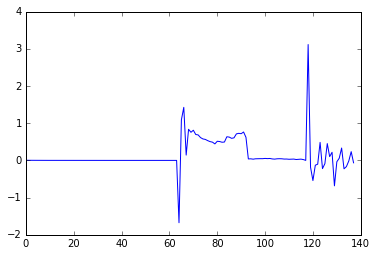

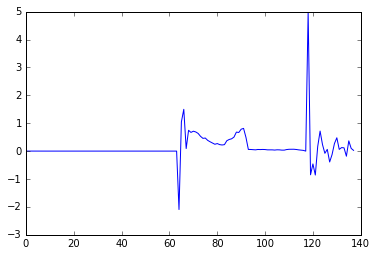

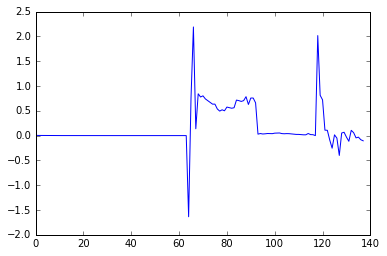

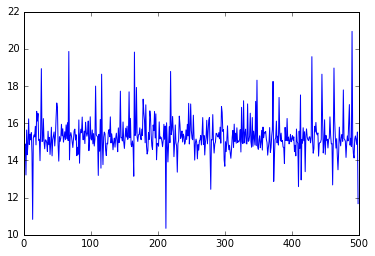

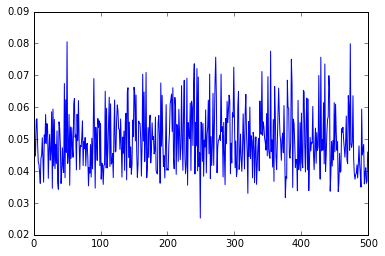

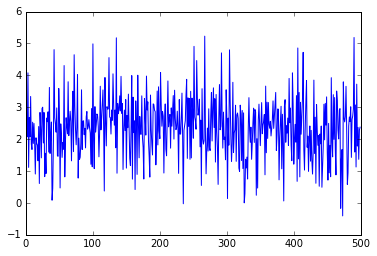

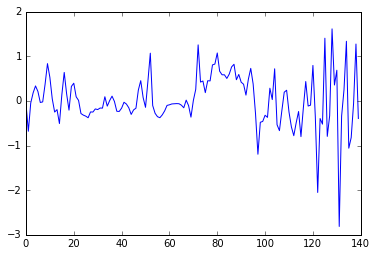

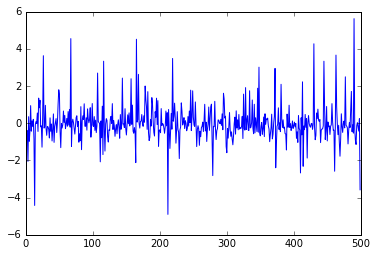

In [108]:
%matplotlib inline  

plt.plot(train_dataset[0,2:])
plt.show()

plt.plot(train_dataset[100,2:])
plt.show()

plt.plot(train_dataset[200,2:])
plt.show()

plt.plot(train_dataset[:,0])
plt.show()

plt.plot(train_dataset[:,100])
plt.show()

plt.plot(train_dataset[:,120])
plt.show()

mu = train_dataset.mean(axis=0)
sigma = train_dataset.std(axis=0)
train_dataset_scaled = (train_dataset - mu) / sigma
test_dataset_scaled = (test_dataset - mu) / sigma

plt.plot(train_dataset_scaled[0,:])
plt.show()

plt.plot(train_dataset_scaled[:,0])
plt.show()

In [109]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

batch_size = 128
num_labels = 10
num_features = 140
hidden_layer1_size = 1024
hidden_layer2_size = 256
hidden_lastlayer_size = 56

regularization_meta = 0.03

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset_scaled)
    keep_prob = tf.placeholder(tf.float32)

    weights_layer1 = tf.Variable(tf.truncated_normal([num_features, hidden_layer1_size], stddev=0.05))
    biases_layer1 = tf.Variable(tf.zeros([hidden_layer1_size]))

    weights_layer2 = tf.Variable(
        tf.truncated_normal([hidden_layer1_size, hidden_layer1_size], stddev=0.05))
    biases_layer2 = tf.Variable(tf.zeros([hidden_layer1_size]))

    weights_layer3 = tf.Variable(
        tf.truncated_normal([hidden_layer1_size, hidden_layer2_size], stddev=0.05))
    biases_layer3 = tf.Variable(tf.zeros([hidden_layer2_size]))

    weights_layer4 = tf.Variable(
        tf.truncated_normal([hidden_layer2_size, hidden_lastlayer_size], stddev=0.05))
    biases_layer4 = tf.Variable(tf.zeros([hidden_lastlayer_size]))

    weights = tf.Variable(tf.truncated_normal([hidden_lastlayer_size, num_labels], stddev=0.1))
    biases = tf.Variable(tf.zeros([num_labels]))

    def getNN4Layer(dSet, use_dropout):
        input_to_layer1 = tf.matmul(dSet, weights_layer1) + biases_layer1
        hidden_layer1_output = tf.nn.relu(input_to_layer1)

        logits_hidden1 = None
        if use_dropout:
            dropout_hidden1 = tf.nn.dropout(hidden_layer1_output, keep_prob)
            logits_hidden1 = tf.matmul(dropout_hidden1, weights_layer2) + biases_layer2
        else:
            logits_hidden1 = tf.matmul(hidden_layer1_output, weights_layer2) + biases_layer2

        hidden_layer2_output = tf.nn.relu(logits_hidden1)

        logits_hidden2 = None
        if use_dropout:
            dropout_hidden2 = tf.nn.dropout(hidden_layer2_output, keep_prob)
            logits_hidden2 = tf.matmul(dropout_hidden2, weights_layer3) + biases_layer3
        else:
            logits_hidden2 = tf.matmul(hidden_layer2_output, weights_layer3) + biases_layer3

        hidden_layer3_output = tf.nn.relu(logits_hidden2)
        logits_hidden3 = None
        if use_dropout:
            dropout_hidden3 = tf.nn.dropout(hidden_layer3_output, keep_prob)
            logits_hidden3 = tf.matmul(dropout_hidden3, weights_layer4) + biases_layer4
        else:
            logits_hidden3 = tf.matmul(hidden_layer3_output, weights_layer4) + biases_layer4

        hidden_layer4_output = tf.nn.relu(logits_hidden3)
        logits = None
        if use_dropout:
            dropout_hidden4 = tf.nn.dropout(hidden_layer4_output, keep_prob)
            logits = tf.matmul(dropout_hidden4, weights) + biases
        else:
            logits = tf.matmul(hidden_layer4_output, weights) + biases

        return logits

    logits = getNN4Layer(tf_train_dataset, True)
    logits_test = getNN4Layer(tf_test_dataset, False)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.3, global_step, 500, 0.90, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(logits_test)

    num_steps = 1001
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in xrange(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset_scaled[offset:(offset + batch_size)]
            batch_labels = train_labels[offset:(offset + batch_size)]

            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, keep_prob: 0.7}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 100 == 0):
                print("Minibatch loss at step", step, ":", l)
#                 print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(
#                     feed_dict={tf_train_dataset: batch_data, tf_train_labels: batch_labels, keep_prob: 1.0}),
#                                                               batch_labels))
        results = test_prediction.eval(feed_dict={keep_prob: 1.0})
        print("Test accuracy: %.1f%%" % accuracy(results, test_labels))
        

Initialized
Minibatch loss at step 0 : 2.32282
Minibatch loss at step 100 : 0.220358
Minibatch loss at step 200 : 0.108485
Minibatch loss at step 300 : 0.0109615
Minibatch loss at step 400 : 0.0198287
Minibatch loss at step 500 : 0.0380643
Minibatch loss at step 600 : 0.00496642
Minibatch loss at step 700 : 0.00489764
Minibatch loss at step 800 : 0.00318905
Minibatch loss at step 900 : 0.000851854
Minibatch loss at step 1000 : 0.00612631
Test accuracy: 66.2%


In [118]:
hit = np.zeros(10)
miss = np.zeros(10)
distances = np.zeros(10)

In [119]:
for prediction, actual in zip(results, test_labels):
    a = np.argmax(prediction)
    b = np.argmax(actual)
    if a == b:
        hit[b]+=1
    else:
        miss[b]+=1
        distances[b]+=abs(a-b)

In [120]:
print(hit)
print(miss)
print(distances)
print(mappings)

[ 46.  33.  46.  23.  40.  25.  19.  28.  36.  35.]
[  4.  17.   4.  27.  10.  25.  31.  22.  14.  15.]
[ 22.  98.  14.  66.  20.  53.  79.  67.  75.  64.]
{0: 'classical', 1: 'blues', 2: 'metal', 3: 'disco', 4: 'hiphop', 5: 'reggae', 6: 'rock', 7: 'country', 8: 'jazz', 9: 'pop'}
